<a href="https://colab.research.google.com/github/daehkim/pair-trading/blob/master/tradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS7641 Machine Learning
*Application of Machine Learning in Pairs Trading*

In [84]:
import pandas as pd
import numpy as np
import os
import datetime
import math
import sklearn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures 

## Price History Table
Here is the price table we used for this function. I used the top 3 stocks as an example. I'll change the data after I get any pair.

In [136]:
# Import training dataset
training_set = pd.read_csv("training_data.csv")

# Remove all the data except the pairs we choose
pairs_list = [[48531, 64390], 
              [83186, 89003], 
              [81294, 82581], 
              [53640, 83597], 
              [43350, 82651], 
              [44644, 90458], 
              [40539, 81584], 
              [21742, 76639]
              ]

for i in range(len(pairs_list)):
    if i==0:
        pairs_training_set = \
            training_set.loc[training_set['PERMNO']==pairs_list[0][0]]
        pairs_training_set = pd.concat([pairs_training_set, 
                   training_set.loc[training_set['PERMNO']==pairs_list[0][1]]])
    else:
        pairs_training_set = pd.concat([pairs_training_set,
                   training_set.loc[training_set['PERMNO']==pairs_list[i][0]]])
        pairs_training_set = pd.concat([pairs_training_set,
                   training_set.loc[training_set['PERMNO']==pairs_list[i][1]]])

training_set = pairs_training_set
training_set.head(20)

,PERMNO,price_20070103,price_20070104,price_20070105,price_20070108,price_20070109,price_20070110,price_20070111,price_20070112,price_20070116,price_20070117,price_20070118,price_20070119,price_20070122,price_20070123,price_20070124,price_20070125,price_20070126,price_20070129,price_20070130,price_20070131,price_20070201,price_20070202,price_20070205,price_20070206,price_20070207,price_20070208,price_20070209,price_20070212,price_20070213,price_20070214,price_20070215,price_20070216,price_20070220,price_20070221,price_20070222,price_20070223,price_20070226,price_20070227,price_20070228,...,at_turn_2012-09,at_turn_2012-10,at_turn_2012-11,at_turn_2012-12,at_turn_2013-01,at_turn_2013-02,at_turn_2013-03,at_turn_2013-04,at_turn_2013-05,at_turn_2013-06,at_turn_2013-07,at_turn_2013-08,at_turn_2013-09,at_turn_2013-10,at_turn_2013-11,at_turn_2013-12,at_turn_2014-01,at_turn_2014-02,at_turn_2014-03,at_turn_2014-04,at_turn_2014-05,at_turn_2014-06,at_turn_2014-07,at_turn_2014-08,at_turn_2014-09,at_turn_2014-10,at_turn_2014-11,at_turn_2014-12,at_turn_2015-01,at_turn_2015-02,at_turn_2015-03,at_turn_2015-04,at_turn_2015-05,at_turn_2015-06,at_turn_2015-07,at_turn_2015-08,at_turn_2015-09,at_turn_2015-10,at_turn_2015-11,at_turn_2015-12
495,48531,20.29,20.29,19.92,20.10,19.99,20.03,20.16,20.26,20.13,20.09,20.08,20.37,20.01,20.22,20.55,20.16,20.53,20.89,21.05,21.27,21.85,21.92,21.43,21.87,21.95,21.56,21.31,21.02,19.88,19.40,19.30,20.00,20.16,20.14,20.14,20.14,20.34,19.74,19.96,...,1.115,1.115,1.124,1.124,1.124,1.007,1.007,1.007,1.002,1.002,1.002,0.936,0.936,0.936,0.871,0.871,0.871,1.003,1.003,1.003,0.855,0.855,0.855,0.841,0.841,0.841,0.847,0.847,0.847,0.894,0.894,0.894,0.872,0.872,0.872,0.902,0.902,0.902,0.902,0.902
652,64390,24.21,24.23,23.75,23.91,23.50,23.44,23.20,23.40,23.38,23.55,23.49,23.28,23.05,23.28,23.35,23.42,23.43,23.52,23.25,23.19,23.67,23.57,23.63,23.67,23.56,23.49,23.32,23.07,23.25,23.35,23.42,23.28,23.08,23.36,23.40,23.28,23.18,22.66,22.94,...,0.721,0.721,0.738,0.738,0.738,0.767,0.767,0.767,0.752,0.752,0.752,0.761,0.761,0.761,0.756,0.756,0.756,0.771,0.771,0.771,0.759,0.759,0.759,0.753,0.753,0.753,0.752,0.752,0.752,0.772,0.772,0.772,0.752,0.752,0.752,0.745,0.745,0.745,0.737,0.737
1187,83186,63.37,63.05,63.07,65.73,66.17,66.73,67.64,67.75,67.48,68.10,67.61,67.76,67.95,68.06,70.50,70.38,69.80,70.77,70.20,70.48,70.97,71.84,71.37,71.48,71.89,71.94,72.22,71.80,71.90,72.53,72.92,72.62,73.37,73.91,73.56,74.08,73.16,70.78,70.42,...,0.738,0.738,0.730,0.730,0.730,0.755,0.755,0.755,0.758,0.758,0.758,0.774,0.774,0.774,0.798,0.798,0.798,0.818,0.818,0.818,0.843,0.843,0.843,0.875,0.875,0.875,0.900,0.900,0.900,0.911,0.911,0.911,0.840,0.840,0.840,0.758,0.758,0.758,0.661,0.661
1572,89003,40.61,40.48,40.34,40.68,40.98,41.32,41.42,41.29,41.31,41.55,41.51,41.60,41.51,41.55,42.57,42.00,42.00,41.70,42.16,42.52,42.54,43.03,43.15,43.23,45.20,45.02,45.40,45.14,45.22,46.75,47.00,47.55,47.55,46.97,47.00,47.04,46.79,45.29,45.92,...,0.412,0.412,0.417,0.417,0.417,0.424,0.424,0.424,0.428,0.428,0.428,0.434,0.434,0.434,0.432,0.432,0.432,0.441,0.441,0.441,0.433,0.433,0.433,0.434,0.434,0.434,0.444,0.444,0.444,0.451,0.451,0.451,0.448,0.448,0.448,0.448,0.448,0.448,0.446,0.446
1110,81294,34.33,34.19,33.35,33.44,33.55,32.73,33.29,33.44,32.85,32.85,32.55,33.11,32.71,32.60,32.81,32.75,32.99,32.99,32.99,32.93,33.10,33.25,33.07,33.03,33.08,33.13,32.77,32.86,33.10,33.16,33.10,33.01,33.39,33.81,33.42,33.31,33.81,32.20,31.90,...,1.202,1.181,1.181,1.181,1.173,1.173,1.173,1.163,1.163,1.163,1.161,1.161,1.161,1.181,1.181,1.181,1.152,1.152,1.152,1.158,1.158,1.158,1.152,1.152,1.152,1.142,1.142,1.142,1.140,1.140,1.140,1.144,1.144,1.144,1.136,1.136,1.136,1.101,1.101,1.101
1158,82581,48.89,48.90,48.41,48.17,46.60,46.70,46.60,46.27,46.39,47.17,47.15,47.96,48.20,48.56,48.96,49.49,49.83,50.16,50.69,50.77,51.16,51.26,51.39,51.58,52.03,52.25,52.04,51.70,51.96,52.24,52.41,52.41,52.51,54.08,53.48,53.86,53.66,52.61,52.17,...,1.830,1.830,1.825,1.825,1.825,1.775,1.775,1.775,1.784,1.784,1.784,1.792

In [147]:
# Filtering the table only for the price history
filter_col = ['PERMNO']
filter_col2 = [col for col in training_set if col.startswith('price_')]
filter_col.extend(filter_col2)

training_set_price = training_set[filter_col]
training_set_price.head(20)

,PERMNO,price_20070103,price_20070104,price_20070105,price_20070108,price_20070109,price_20070110,price_20070111,price_20070112,price_20070116,price_20070117,price_20070118,price_20070119,price_20070122,price_20070123,price_20070124,price_20070125,price_20070126,price_20070129,price_20070130,price_20070131,price_20070201,price_20070202,price_20070205,price_20070206,price_20070207,price_20070208,price_20070209,price_20070212,price_20070213,price_20070214,price_20070215,price_20070216,price_20070220,price_20070221,price_20070222,price_20070223,price_20070226,price_20070227,price_20070228,...,price_20151104,price_20151105,price_20151106,price_20151109,price_20151110,price_20151111,price_20151112,price_20151113,price_20151116,price_20151117,price_20151118,price_20151119,price_20151120,price_20151123,price_20151124,price_20151125,price_20151127,price_20151130,price_20151201,price_20151202,price_20151203,price_20151204,price_20151207,price_20151208,price_20151209,price_20151210,price_20151211,price_20151214,price_20151215,price_20151216,price_20151217,price_20151218,price_20151221,price_20151222,price_20151223,price_20151224,price_20151228,price_20151229,price_20151230,price_20151231
495,48531,20.29,20.29,19.92,20.10,19.99,20.03,20.16,20.26,20.13,20.09,20.08,20.37,20.01,20.22,20.55,20.16,20.53,20.89,21.05,21.27,21.85,21.92,21.43,21.87,21.95,21.56,21.31,21.02,19.88,19.40,19.30,20.00,20.16,20.14,20.14,20.14,20.34,19.74,19.96,...,37.14000,37.11000,36.66000,36.75,37.45,38.445,37.39000,37.38000,38.24000,38.14000,38.66000,38.69,38.74000,38.61,38.04,38.16000,38.43000,37.07000,36.77,36.60000,36.19000,36.42000,35.79,35.40000,35.17000,34.40000,34.25000,35.25000,35.71000,36.31000,35.94000,35.67000,35.72000,35.48000,35.85,35.14000,34.68000,35.00,34.80000,34.30000
652,64390,24.21,24.23,23.75,23.91,23.50,23.44,23.20,23.40,23.38,23.55,23.49,23.28,23.05,23.28,23.35,23.42,23.43,23.52,23.25,23.19,23.67,23.57,23.63,23.67,23.56,23.49,23.32,23.07,23.25,23.35,23.42,23.28,23.08,23.36,23.40,23.28,23.18,22.66,22.94,...,33.15000,32.38000,32.01000,31.47,31.45,31.580,31.04000,30.72000,30.93000,30.75000,31.40000,31.40,31.58000,31.76,31.74,31.30000,31.12000,30.82000,31.17,30.83000,30.39000,31.22000,31.02,30.96000,30.66000,30.69000,30.29000,30.77000,30.95000,31.77000,31.48000,30.83000,31.12000,31.83000,32.00,32.00000,31.96000,32.46,32.32000,31.80000
1187,83186,63.37,63.05,63.07,65.73,66.17,66.73,67.64,67.75,67.48,68.10,67.61,67.76,67.95,68.06,70.50,70.38,69.80,70.77,70.20,70.48,70.97,71.84,71.37,71.48,71.89,71.94,72.22,71.80,71.90,72.53,72.92,72.62,73.37,73.91,73.56,74.08,73.16,70.78,70.42,...,124.70000,124.21000,124.74000,123.80,123.52,123.510,121.06000,119.39000,121.32000,120.63000,121.00000,122.39,123.00000,122.20,123.40,123.74000,124.42000,122.28000,122.57,121.33000,119.86000,121.47000,120.11,118.86000,115.60000,116.40000,112.99000,113.61000,113.94000,116.56000,116.14000,114.89000,115.32000,114.54000,115.16,115.10000,115.36000,116.65,115.48000,114.06000
1572,89003,40.61,40.48,40.34,40.68,40.98,41.32,41.42,41.29,41.31,41.55,41.51,41.60,41.51,41.55,42.57,42.00,42.00,41.70,42.16,42.52,42.54,43.03,43.15,43.23,45.20,45.02,45.40,45.14,45.22,46.75,47.00,47.55,47.55,46.97,47.00,47.04,46.79,45.29,45.92,...,65.54000,66.18000,67.19000,66.35,66.51,67.080,66.31000,65.10000,65.50000,65.61000,66.12000,66.08,66.41000,65.55,64.78,64.53000,64.72000,63.67000,64.49,64.98000,64.07000,65.04000,63.51,63.05000,63.45000,62.88000,61.20000,61.11000,61.62000,62.03000,59.88000,58.52000,59.16000,59.85000,61.19,61.11000,61.00000,61.59,60.99000,60.60000
1110,81294,34.33,34.19,33.35,33.44,33.55,32.73,33.29,33.44,32.85,32.85,32.55,33.11,32.71,32.60,32.81,32.75,32.99,32.99,32.99,32.93,33.10,33.25,33.07,33.03,33.08,33.13,32.77,32.86,33.10,33.16,33.10,33.01,33.39,33.81,33.42,33.31,33.81,32.20,31.90,...,96.91000,96.95000,96.39000,95.64,96.46,96.760,95.03000,95.21000,96.40000,96.79000,98.35000,98.28,98.48000,99.80,100.03,100.66000,100.70000,98.77000,99.50,99.34000,98.30000,99.52000,100.27,100.4300

## Create the spread funtion (price pair's relation)
We will create the function of spread in here. The basic function of spread is defined as blow:

$Spread = log(a) - nlog(b)$

where the 'a' and 'b' are prices of stocks A and B respectively and the 'n' is hedge ratio. Our target is finding dynamics of spread based on the machine learning. We will use the supervised machine learning to implement this part and the possible candidates are 'linear regression' and 'support vector machine (SVM)'

In [116]:
def create_spread_function(a, b, start_t, end_t, alg='log'):
    """
    * Input
        - a, b: Stock A and B's price history
        - start_t, end_t: start/end time of the analysis on the data. 
            They use the same unit with the data. For example, 0 means the 
            first data of the a and b. 
            (Analyze the data from a[start_t], b[start_t] to a[end_t], 
            b[end_t])
        - alg: Type of algorithm. The 'log' means the log normalization
    * Output
        - The function of spread. Output of this function is spread and z_score.
    * Function
        - Apply the supervised machine learning to find the dynamics of
        spread
    """
    
    def log_spread_func(a, b):
        spread = math.log(b) - w_avg * math.log(a)
        z_score = spread/w_std

        return (spread, z_score)

    def lr_spread_func(a, b):
        # Change the a to polynomial form
        a, b = np.log(a), np.log(b)
        a = a * np.ones((1, 1))
        poly = PolynomialFeatures(degree = degree)
        a = poly.fit_transform(a)

        # Calculate the spread & z_score
        spread = b - regr.predict(a)
        z_score = spread/spread_std

        return (spread, z_score)

    # Slice the date
    target_a = a[start_t:end_t]
    target_b = b[start_t:end_t]

    # use the log function
    target_a = np.log(target_a)
    target_b = np.log(target_b)
    
    total_date = end_t-start_t

    # Find the coefficient of the log normalization
    if alg == 'log':
        print("Log normalization")

        # Calculate the weight
        w_list = target_b/target_a
        w_avg = np.average(w_list)

        # Calculate the standard deviation for the z-score calculation
        w_std = np.std(w_list)

        return log_spread_func

    # Find the coefficient of the linear regression
    elif alg == 'lr':
        print("Linear regression")

        # Change the data from 1-D to 2-D
        target_a = target_a[:,np.newaxis]

        # Change the data to the polonomial
        degree = 4
        poly = PolynomialFeatures(degree = degree)
        target_a = poly.fit_transform(target_a)

        # Train the data using linear regression
        regr = linear_model.LinearRegression()
        regr.fit(target_a, target_b)
        
        # Calculate the standard deviation of spread for the z-score calculation
        b_pred = regr.predict(target_a)
        spread = target_b-b_pred
        spread_std = np.std(spread)

        # Generate the plot to verify the function
        """
        x = np.arange(total_date)
        z_score = spread/spread_std
        plt.plot(x, z_score)
        plt.show()
        """

        return lr_spread_func


    print("Check the algorithm. Input was " + alg)

    pass

### How to use

Here, we will see how to use the spread function.
Right now, the results are bad because the stock a and b is randomly choosen and does not have any relation.

pairs = ([48531, 64390])

Log normalization


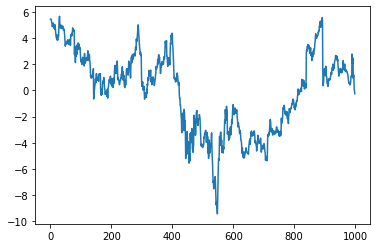

Linear regression


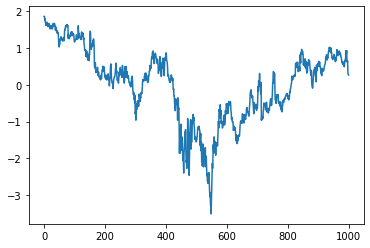

pairs = ([83186, 89003])

Log normalization


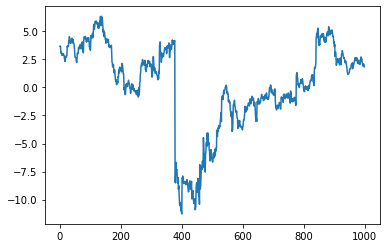

Linear regression


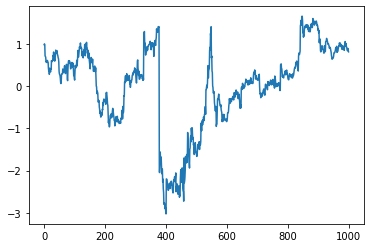

pairs = ([81294, 82581])

Log normalization


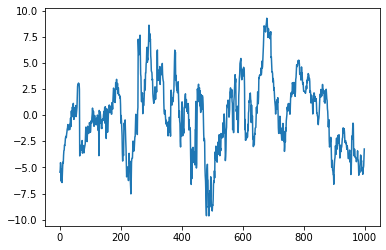

Linear regression


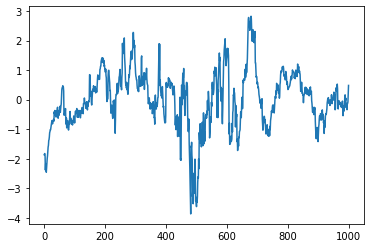

pairs = ([53640, 83597])

Log normalization


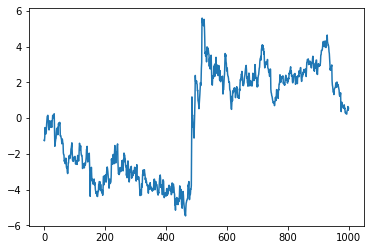

Linear regression


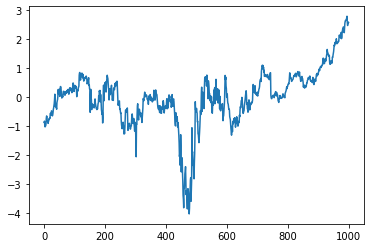

pairs = ([43350, 82651])

Log normalization


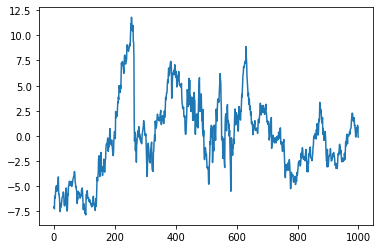

Linear regression


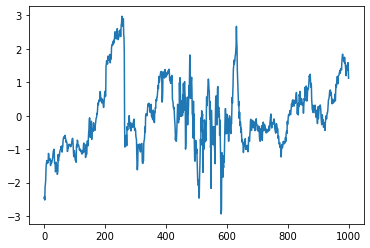

pairs = ([44644, 90458])

Log normalization


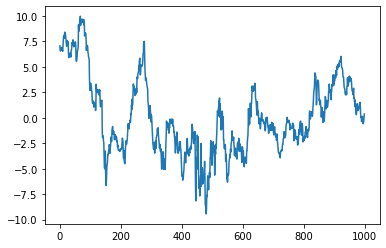

Linear regression


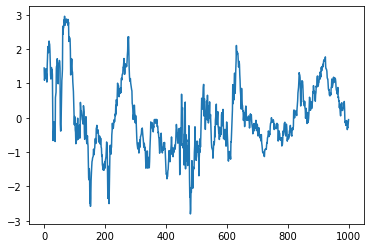

pairs = ([40539, 81584])

Log normalization


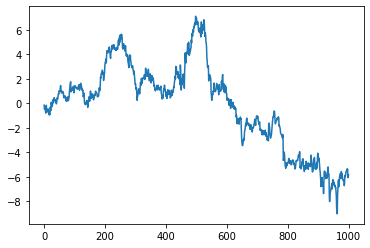

Linear regression


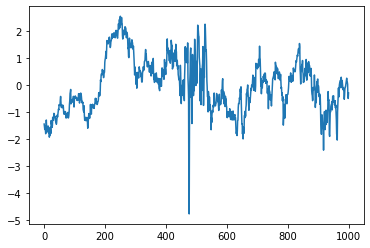

pairs = ([21742, 76639])

Log normalization


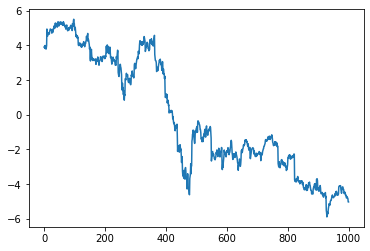

Linear regression


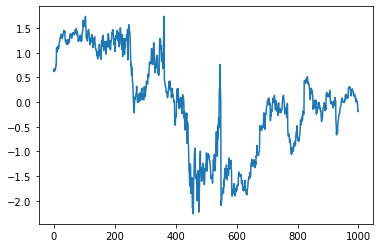

In [152]:
for i in range(len(pairs_list)):
    print("pairs = (" + str(pairs_list[i]) + ")\n")
    # Generate input for the test
    a = training_set_price.iloc[2*i].to_numpy()[1:]
    b = training_set_price.iloc[2*i+1].to_numpy()[1:]

    # Check the function based on the log normalization
    spread_func = create_spread_function(a, b, 0, 1000, 'log')
    (spread, z_score) = spread_func(a[0], b[0])

    # Generate the graph about log based z_score
    x = np.arange(1000)
    z_score_history = np.zeros((1000))
    for i in range(1000):
        (spread, z_score_history[i]) = spread_func(a[i], b[i])
    plt.plot(x, z_score_history)
    plt.show()

    # Check the function based on the linear regression
    spread_func = create_spread_function(a, b, 0, 1000, 'lr')
    (spread, z_score) = spread_func(a[0], b[0])

    # Generate the graph about log based z_score
    for i in range(1000):
        (spread, z_score_history[i]) = spread_func(a[i], b[i])
    plt.plot(x, z_score_history)
    plt.show()
    print("======================================================")

## Generate the spread function list
We also generated the spread function list. The spread function list is needed for the backtesting. It will be used in the z-score matrix generation

In [ ]:
def gen_spread_func_list(stock_pair_list, training_set, start_t, end_t, alg):
    """
    * Input: stock_pair_list, training_set, start_t, end_t, algorithm
    * Output: spread_func_list
    * Function: generate all the spread function based on the stock pairs list
    """
    spread_func_list = []

    # Let the training_set includes only PERMNO and price history
    filter_col = ['PERMNO']
    price_list = [col for col in training_set if col.startswith('price_')]
    filter_col.extend(price_list)
    training_set = training_set[filter_col]

    for pair in stock_pair_list:
        # Generate the price data for each stock in the pair
        training_set_a = training_set.loc[training_set['PERMNO'] == pair[0]]
        training_set_a = training_set_a[price_list].iloc[0]
        training_set_b = training_set.loc[training_set['PERMNO'] == pair[1]]
        training_set_b = training_set_b[price_list].iloc[0]

        # Run the create_spread_function
        spread_func = create_spread_function(
            training_set_a, b, start_t, end_t, alg)
        spread_func_list.append(spread_func) 

    return spread_func_list

### How to use
We will test the function with the 3 input pairs ([10025, 10026], [10025, 10032], [10026, 10032]). The stocks are distinguished based on the PERMNO. 

In [ ]:
# Generate the inputs for the test
stock_pair_list = [[10025, 10026], [10025, 10032], [10026, 10032]]
a = training_set_price.loc[0]
b = training_set_price.loc[1]

# Generate the list of the spread functions
spread_func_list = gen_spread_func_list(
    stock_pair_list, training_set, 0, 1000, 'lr')

# Try to run one of the spread function
(spread, z_score) = spread_func_list[0](a[0], b[0])
print(spread, z_score)


Linear regression
Linear regression
Linear regression
8.042285297435534 53.31521967302066


## Generate the z-score matrix
Generate the z-score matrix based on the spread function list.
It will be used for our strategy to deciding how much stocks we will buy/sell.
* Input: stock pairs list, stock's present price list
* Output: z-score matrix
* Function: calculate the z-scores in the stock pairs list and generate the matrix about z-score

In [ ]:
def gen_z_score_matrix(stock_pair_list, current_price_list, spread_func_list):
    """
    * Input: stock_pair_list, current_price_list, spread_func_list
    * Output: z-score matrix
    * Function: run the spread function with the current price list. 
    """

    # Generate the empty data frame based on the stock_pair_list
    columns = []
    index = []
    for pair in stock_pair_list:
        if pair[0] in index:
            pass
        else:
            index.append(pair[0])
        
        if pair[1] in columns:
            pass
        else:
            columns.append(pair[1])
        
    z_score_matrix = pd.DataFrame(index=index, columns = columns)

    # Fill the data in the data frame
    for i, pair in enumerate(stock_pair_list):

        # Find the current price
        price_a = current_price_list[current_price_list['PERMNO']==pair[0]]
        price_a = price_a.iloc[0,1]
        price_b = current_price_list[current_price_list['PERMNO']==pair[1]]
        price_b = price_b.iloc[0,1]

        # Run the spread_function and calculate the z_score
        (spread, z_score) = spread_func_list[i](price_a, price_b)

        # Fill the z_score on the data frame
        z_score_matrix.at[pair[0], pair[1]] = z_score

    return z_score_matrix

### How to use
We will test the function with the 3 input pairs ([10025, 10026], [10025, 10032], [10026, 10032]). The stocks are distinguished based on the PERMNO.

In [ ]:
# Generate the input for the test
stock_pair_list = [[10025, 10026], [10025, 10032], [10026, 10032]]
filter_col = ['PERMNO', 'price_20070103']
current_price_list = training_set[filter_col]

# Run the z-score matrix generation function
z_score_matrix = gen_z_score_matrix(
    stock_pair_list, current_price_list, spread_func_list)

print(z_score_matrix)

         10026        10032
10025  53.3152      165.345
10026      NaN  1.20342e+18



## Generate buy/sell the stock matrix
Based on the z-score matrix, we need to decide which stocks to by and which stocks to sell. We will buy the stock if the z-score is above certain point. (Ex. 2-sigma) It will be the argument. In the same way, if the z-score reaches below the certain point, we will sell the stock. (Ex. 0) We also need to care about when the pair of stocks shows the unusual behavior. When we buy at the 2-sigma and if it reaches the 3-sigma, we should sell the stock to stop the loss. 
* Input: entry point, stop loss point, take profit point, commission for trade, z-score matrix
* Output: buy matrix, sell matrix (each component is amount of stock we will buy/sell)
* Function: decide our action based on the z-score matrix

In [ ]:
def gen_action_matrix():
    pass

In [ ]:
# Code verification